# scRFEimplot

In [ ]:
# plot the Gini importances
# UNTOUCHED CODE FROM ANGELA
def scRFEimplot(X_new,y):
    
    rf= RandomForestClassifier(random_state=0).fit(X_new, y)
    result = permutation_importance(rf, X_new.todense(), y, n_repeats=10, random_state=0,
                                    n_jobs=-1)

    fig, ax = plt.subplots()
    sorted_idx = result.importances_mean.argsort()
    ax.boxplot(result.importances[sorted_idx].T*100,
               vert=False, labels=range(X_new.shape[1]))
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.show()
    
    return fig,ax

In [30]:
# import dependencies
import numpy as np
import pandas as pd
import scanpy as sc
import random
import logging as logg
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn.metrics import accuracy_score
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

In [31]:
import scRFE
import numpy as np
from scRFE import scRFE #why is scRFE.scRFE not working? 
# import pan

In [5]:
# from scRFE.scRFE import scRFE
from anndata import read_h5ad
adata = read_h5ad('/Users/madelinepark/Downloads/Liver_droplet.h5ad')

/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['distances'] to .obsp['distances'].

This is where adjacency matrices should go now.
  FutureWarning,
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/anndata/compat/__init__.py:161: FutureWarning: Moving element from .uns['neighbors']['connectivities'] to .obsp['connectivities'].

This is where adjacency matrices should go now.
  FutureWarning,


In [32]:
def columnToString (dataMatrix):
    cat_columns = dataMatrix.obs.select_dtypes(['category']).columns
    dataMatrix.obs[cat_columns] = dataMatrix.obs[cat_columns].astype(str)
    return dataMatrix

In [33]:
def filterNormalize (dataMatrix, classOfInterest, verbosity):
    np.random.seed(644685)
    dataMatrix = dataMatrix[dataMatrix.obs[classOfInterest]!='nan']
    dataMatrix = dataMatrix[~dataMatrix.obs[classOfInterest].isna()]
    if verbosity == True:
        print ('Removed NaN observations in the selected category')
    return dataMatrix

In [34]:
def labelSplit (dataMatrix, classOfInterest, labelOfInterest, verbosity):
    dataMatrix = filterNormalize (dataMatrix, classOfInterest, verbosity)
    dataMatrix.obs['classification_group'] = 'B'
    dataMatrix.obs.loc[dataMatrix.obs[dataMatrix.obs[classOfInterest]==labelOfInterest]
                   .index,'classification_group'] = 'A' #make labels based on A/B of classofInterest
    return dataMatrix

In [35]:
def downsampleToSmallestCategory(dataMatrix, random_state, min_cells,
                                 keep_small_categories, verbosity,
                                 classOfInterest = 'classification_group'):
    counts = dataMatrix.obs[classOfInterest].value_counts(sort=False)
    if len(counts[counts < min_cells]) > 0 and keep_small_categories is False:
        logg.warning(
            "The following categories have less than {} cells and will be "
            "ignored: {}".format(min_cells, dict(counts[counts < min_cells]))
        )
    min_size = min(counts[counts >= min_cells])
    sample_selection = None
    for sample, num_cells in counts.items():
        if num_cells <= min_cells:
            if keep_small_categories:
                sel = dataMatrix.obs.index.isin(
                    dataMatrix.obs[dataMatrix.obs[classOfInterest] == sample].index)
            else:
                continue
        else:
            sel = dataMatrix.obs.index.isin(
                dataMatrix.obs[dataMatrix.obs[classOfInterest] == sample]
                .sample(min_size, random_state=random_state)
                .index
            )
        if sample_selection is None:
            sample_selection = sel
        else:
            sample_selection |= sel
#     logg.info(
#         "The cells in category {!r} had been down-sampled to have each {} cells. "
#         "The original counts where {}".format(classOfInterest, min_size, dict(counts))
#     )
    return dataMatrix[sample_selection].copy()

In [36]:
def makeOneForest (dataMatrix, classOfInterest, labelOfInterest, nEstimators,
                   randomState,  min_cells, keep_small_categories,
                   nJobs, oobScore, Step, Cv, verbosity):
    #need to add verbose arg details
    """
    Builds and runs a random forest for one label in a class of interest
    Parameters
    ----------
    dataMatrix : anndata object
        The data file of interest
    classOfInterest : str
        The class you will split the data by in the set of dataMatrix.obs
    labelOfInterest : str
        The specific label within the class that the random forezt will run a
        "one vs all" classification on
    nEstimators : int
        The number of trees in the forest
    randomState : int
        Controls random number being used
    nJobs : int
        The number of jobs to run in parallel
    oobScore : bool
        Whether to use out-of-bag samples to estimate the generalization accuracy
    Step : float
        Corresponds to percentage of features to remove at each iteration
    Cv : int
        Determines the cross-validation splitting strategy
    verbosity : bool
        Whether to include print statements.
    Returns
    -------
    feature_selected : list
        list of top features from random forest
    selector.estimator_.feature_importances_ : list
        list of top ginis corresponding to to features
    """
    splitDataMatrix = labelSplit (dataMatrix, classOfInterest, labelOfInterest, verbosity)

    downsampledMatrix = downsampleToSmallestCategory (dataMatrix = splitDataMatrix,
    random_state = randomState, min_cells = min_cells,
        keep_small_categories = keep_small_categories, verbosity = verbosity,
        classOfInterest = 'classification_group' )

    if verbosity == True:
        print(labelOfInterest)
        print(pd.DataFrame(downsampledMatrix.obs.groupby(['classification_group',classOfInterest])[classOfInterest].count()))

    feat_labels = downsampledMatrix.var_names
    X = downsampledMatrix.X
    y = downsampledMatrix.obs['classification_group'] #'A' or 'B' labels from labelSplit

    clf = RandomForestClassifier(n_estimators = nEstimators, random_state = randomState,
                                 n_jobs = nJobs, oob_score = oobScore)

    Cv = StratifiedKFold(Cv)
    selector = RFECV(clf, step = Step, cv = Cv, scoring='f1_weighted', min_features_to_select=2)

    clf.fit(X, y)
    selector.fit(X, y)
    feature_selected = feat_labels[selector.support_]
    dataMatrix.obs['classification_group'] = 'B'

    X_new = selector.fit_transform(X, y)
    selector.fit(X_new, y)
    score = selector.score(X_new, y)
    feature_selected = feature_selected[selector.support_]

    return feature_selected, selector.estimator_.feature_importances_,score,X_new,y


In [38]:
test1 = makeOneForest(dataMatrix=adata, classOfInterest='age', labelOfInterest='3m', nEstimators=10,
                   randomState=0,  min_cells=15, keep_small_categories=True,
                   nJobs=-1, oobScore=True, Step=0.2, Cv=3, verbosity=True
)

Trying to set attribute `.obs` of view, copying.


Removed NaN observations in the selected category
3m
                          age
classification_group age     
A                    1m     0
                     3m   854
                     18m    0
                     21m    0
                     24m    0
                     30m    0
B                    1m   359
                     3m     0
                     18m   87
                     21m   44
                     24m   11
                     30m  353


/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-package

/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-package

/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-package

/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:523: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/_forest.py:528: RuntimeWarning: invalid value encountered in true_divide
  predictions[k].sum(axis=1)[:, np.newaxis])
/Users/madelinepark/opt/anaconda3/lib/python3.7/site-package

In [40]:
type(test1[4])

pandas.core.series.Series

In [64]:
pwd

'/Users/madelinepark/Desktop'

In [65]:
# plot the Gini importances
def scRFEimplot(X_new,y):
    """
    Plots permutation importance of each feature selected by scRFE.
    Parameters
    ----------
    X_new : sparse matrix 
    Transformed array.
    y : pandas series
    Target labels.
    Returns
    -------
    fig_df : TYPE? 
    
    """
#     fig_df = {}
    
    rf = RandomForestClassifier(random_state=0).fit(X_new, y)
    result = permutation_importance(rf, X_new.todense(), y, n_repeats=10, random_state=0,
        n_jobs=-1)
    fig, ax = plt.subplots()
    sorted_idx = result.importances_mean.argsort()
    ax.boxplot(result.importances[sorted_idx].T*100,
        vert=False, labels=range(X_new.shape[1]))
    ax.set_title("Permutation Importance of each feature")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.savefig('plot.png', dpi=300, bbox_inches='tight') #trying to show

    plt.show()
#     fig_df[labelOfInterest] = (fig,ax)

    return plt

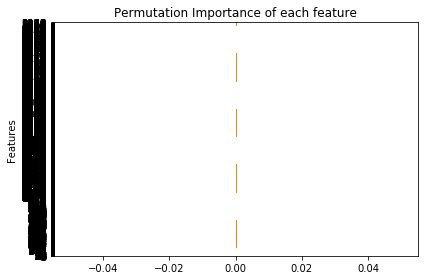

In [66]:
test3 = scRFEimplot(X_new = test1[3], y = test1[4])

In [48]:
type(test3)

module

In [50]:
cd /Users/madelinepark/Desktop

/Users/madelinepark/Desktop


In [57]:
import numpy as np
import matplotlib.pyplot as plt
import pickle as pl

# # Plot simple sinus function
# fig_handle = plt.figure()
# x = np.linspace(0,2*np.pi)
# y = np.sin(x)
# plt.plot(x,y)

# Save figure handle to disk
# pl.dump(test3,file('sinus.pickle','w'))
test3

<module 'matplotlib.pyplot' from '/Users/madelinepark/opt/anaconda3/lib/python3.7/site-packages/matplotlib/pyplot.py'>

In [63]:
# matplotlib.pyplot.savefig(*args, **kwargs)
pl.dump(test3, file)

NameError: name 'file' is not defined

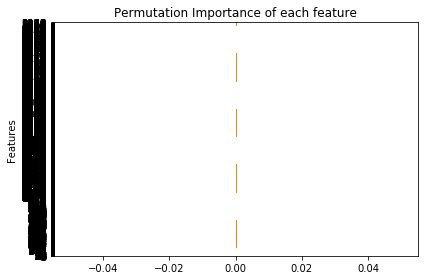

NameError: name 'labelOfInterest' is not defined

In [43]:
test2 = scRFEimplot(X_new = test1[3], y = test1[4])

In [44]:
type(test2)

NameError: name 'test2' is not defined